<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/LLM_rinna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLMによる植物ドメイン画像の視覚的質問応答


## ライセンス

- トマト疫病画像
    - Scot Nelson from Honolulu, Hawaii, USA, CC BY-SA 2.0 <https://creativecommons.org/licenses/by-sa/2.0>, via Wikimedia Commons

In [ ]:
#https://huggingface.co/rinna/bilingual-gpt-neox-4b-minigpt4

## 環境設定

In [1]:
!git clone https://github.com/Vision-CAIR/MiniGPT-4.git
%cd ./MiniGPT-4
!git checkout 22d8888 # latest version as of July 31, 2023.
!wget https://huggingface.co/rinna/bilingual-gpt-neox-4b-minigpt4/resolve/main/customized_mini_gpt4.py
!wget https://huggingface.co/rinna/bilingual-gpt-neox-4b-minigpt4/resolve/main/checkpoint.pth
%cd /content

Cloning into 'MiniGPT-4'...
remote: Enumerating objects: 1797, done.
remote: Counting objects: 100% (884/884), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 1797 (delta 719), reused 657 (delta 657), pack-reused 913
Receiving objects: 100% (1797/1797), 65.21 MiB | 14.07 MiB/s, done.
Resolving deltas: 100% (1047/1047), done.
/content/MiniGPT-4
Note: switching to '22d8888'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 22d8888 Update README.md
--2024-04-26 14:06:28--  https://huggingface

レポジトリに備わっているenvrionment.yamlはconda用の環境設定ファイルです。pipでインストールできよう、requirements.txtに変換します。

In [2]:
import yaml

def convert_env_to_requirements(env_file, req_file):
    ignore_list = ['python', 'cudatoolkit', 'pip', 'pytorch', 'pytorch-mutex', 'torchaudio', 'torchvision']
    try:
        with open(env_file, 'r') as file:
            env_content = yaml.safe_load(file)
            dependencies = env_content.get('dependencies', [])

            with open(req_file, 'w') as req:
                for dep in dependencies:
                    if isinstance(dep, str):
                        package_name = dep.split('=')[0]
                        if package_name not in ignore_list:
                            req.write(dep + '\n')
                    elif isinstance(dep, dict) and 'pip' in dep:
                        for pip_dep in dep['pip']:
                            package_name = pip_dep.split('==')[0]
                            if package_name not in ignore_list:
                                req.write(pip_dep + '\n')

        print(f"requirements.txt generated successfully at {req_file}")
    except Exception as e:
        print(f"Error: {e}")

convert_env_to_requirements("/content/MiniGPT-4/environment.yml","/content/MiniGPT-4/requirements.txt")


requirements.txt generated successfully at /content/MiniGPT-4/requirements.txt


In [3]:
!pip install -qqq -r /content/MiniGPT-4/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 48.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 72

In [4]:
# utf-8 locale bug fix
import locale
locale.getpreferredencoding = lambda: "UTF-8"


import sys
sys.path.append("/content/MiniGPT-4")
import torch
import requests
from PIL import Image
from minigpt4.processors.blip_processors import Blip2ImageEvalProcessor
from customized_mini_gpt4 import CustomizedMiniGPT4

モデルをロードします。

In [5]:
ckpt_path = "/content/MiniGPT-4/checkpoint.pth"
model = CustomizedMiniGPT4(gpt_neox_model="rinna/bilingual-gpt-neox-4b")
tokenizer = model.gpt_neox_tokenizer

if torch.cuda.is_available():
    model = model.to("cuda")

if ckpt_path is not None:
    print("Load BLIP2-LLM Checkpoint: {}".format(ckpt_path))
    ckpt = torch.load(ckpt_path, map_location="cpu")
    model.load_state_dict(ckpt['model'], strict=False)

vis_processor = Blip2ImageEvalProcessor()

Loading VIT


100%|██████████| 1.89G/1.89G [01:26<00:00, 23.3MB/s]


freeze vision encoder
Loading VIT Done
Loading Q-Former


100%|██████████| 413M/413M [00:19<00:00, 22.5MB/s]


freeze Qformer
Loading Q-Former Done
Loading LLM


Loading LLM Done
Load BLIP2-LLM Checkpoint: /content/MiniGPT-4/checkpoint.pth


## 猫の写真について質問する

推論対象の画像を取得し、表示します。

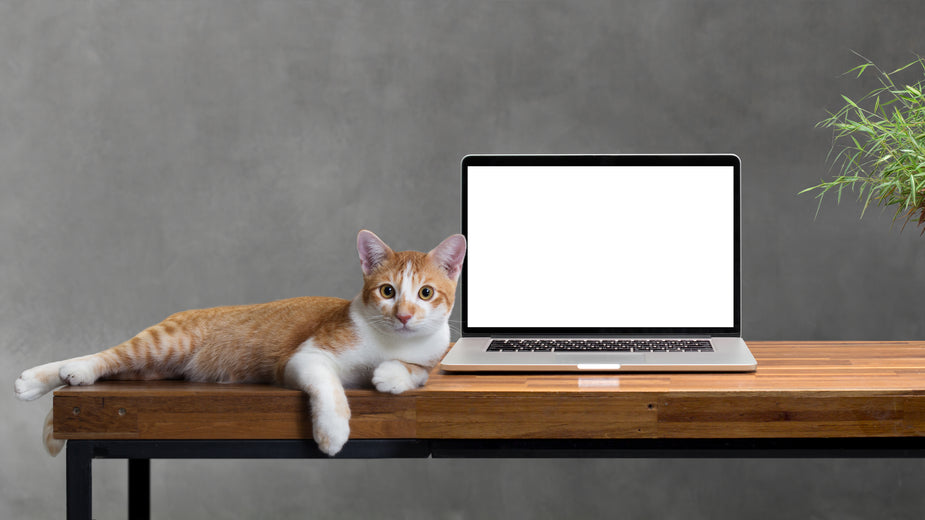

In [6]:
image_url = "https://huggingface.co/rinna/bilingual-gpt-neox-4b-minigpt4/resolve/main/sample.jpg"
raw_image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
image = vis_processor(raw_image).unsqueeze(0).to(model.device)
image_emb = model.encode_img(image)
display(raw_image)

LLMに質問するプロンプトを用意します。プロンプトの形式はLLMによって異なりますので注意してください。ここでは写真がどのようなものであるか、ユーザーとシステムの一問一答をあらかじめ用意し、２つ目の質問を答えさせようとしています。

In [7]:
prompt = [
    {
        "speaker": "ユーザー",
        "text": "<Img><ImageHere></Img> What can you see?"
    },
    {
        "speaker": "システム",
        "text": "a cat on a table with a laptop"
    },
    {
        "speaker": "ユーザー",
        "text": "猫はどんな体勢をしていますか？"
    },
]
prompt = [
    f"{uttr['speaker']}: {uttr['text']}"
    for uttr in prompt
]
prompt = "\n".join(prompt)
prompt = (
    prompt
    + "\n"
    + "システム: "
)
print(prompt)

ユーザー: <Img><ImageHere></Img> What can you see?
システム: a cat on a table with a laptop
ユーザー: 猫はどんな体勢をしていますか？
システム: 


推論し、出力を得ます。入力には埋め込みベクタに変換した画像とプロンプト両方を使用しています。以下のセルを実行するたびに結果が変わります。答えの一貫性はtempratureやtop_pの値によって変わります。

In [8]:
embs = model.get_context_emb(prompt, [image_emb])

output_ids = model.gpt_neox_model.generate(
    inputs_embeds=embs,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.5,
    top_p=0.85,
    pad_token_id=tokenizer.pad_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

output = tokenizer.decode(output_ids.tolist()[0], skip_special_tokens=True)
print(output)

座っている


## 植物関連画像で質問
トマト疫病に罹患した画像を読み込ませ、質問をしてみましょう。

--2024-04-26 14:28:12--  https://upload.wikimedia.org/wikipedia/commons/d/df/Tomato_late_blight_foliar_lesions_%285816740026%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2251989 (2.1M) [image/jpeg]
Saving to: ‘tomato.jpg’

tomato.jpg          100%[===================>]   2.15M  2.66MB/s    in 0.8s    

2024-04-26 14:28:13 (2.66 MB/s) - ‘tomato.jpg’ saved [2251989/2251989]



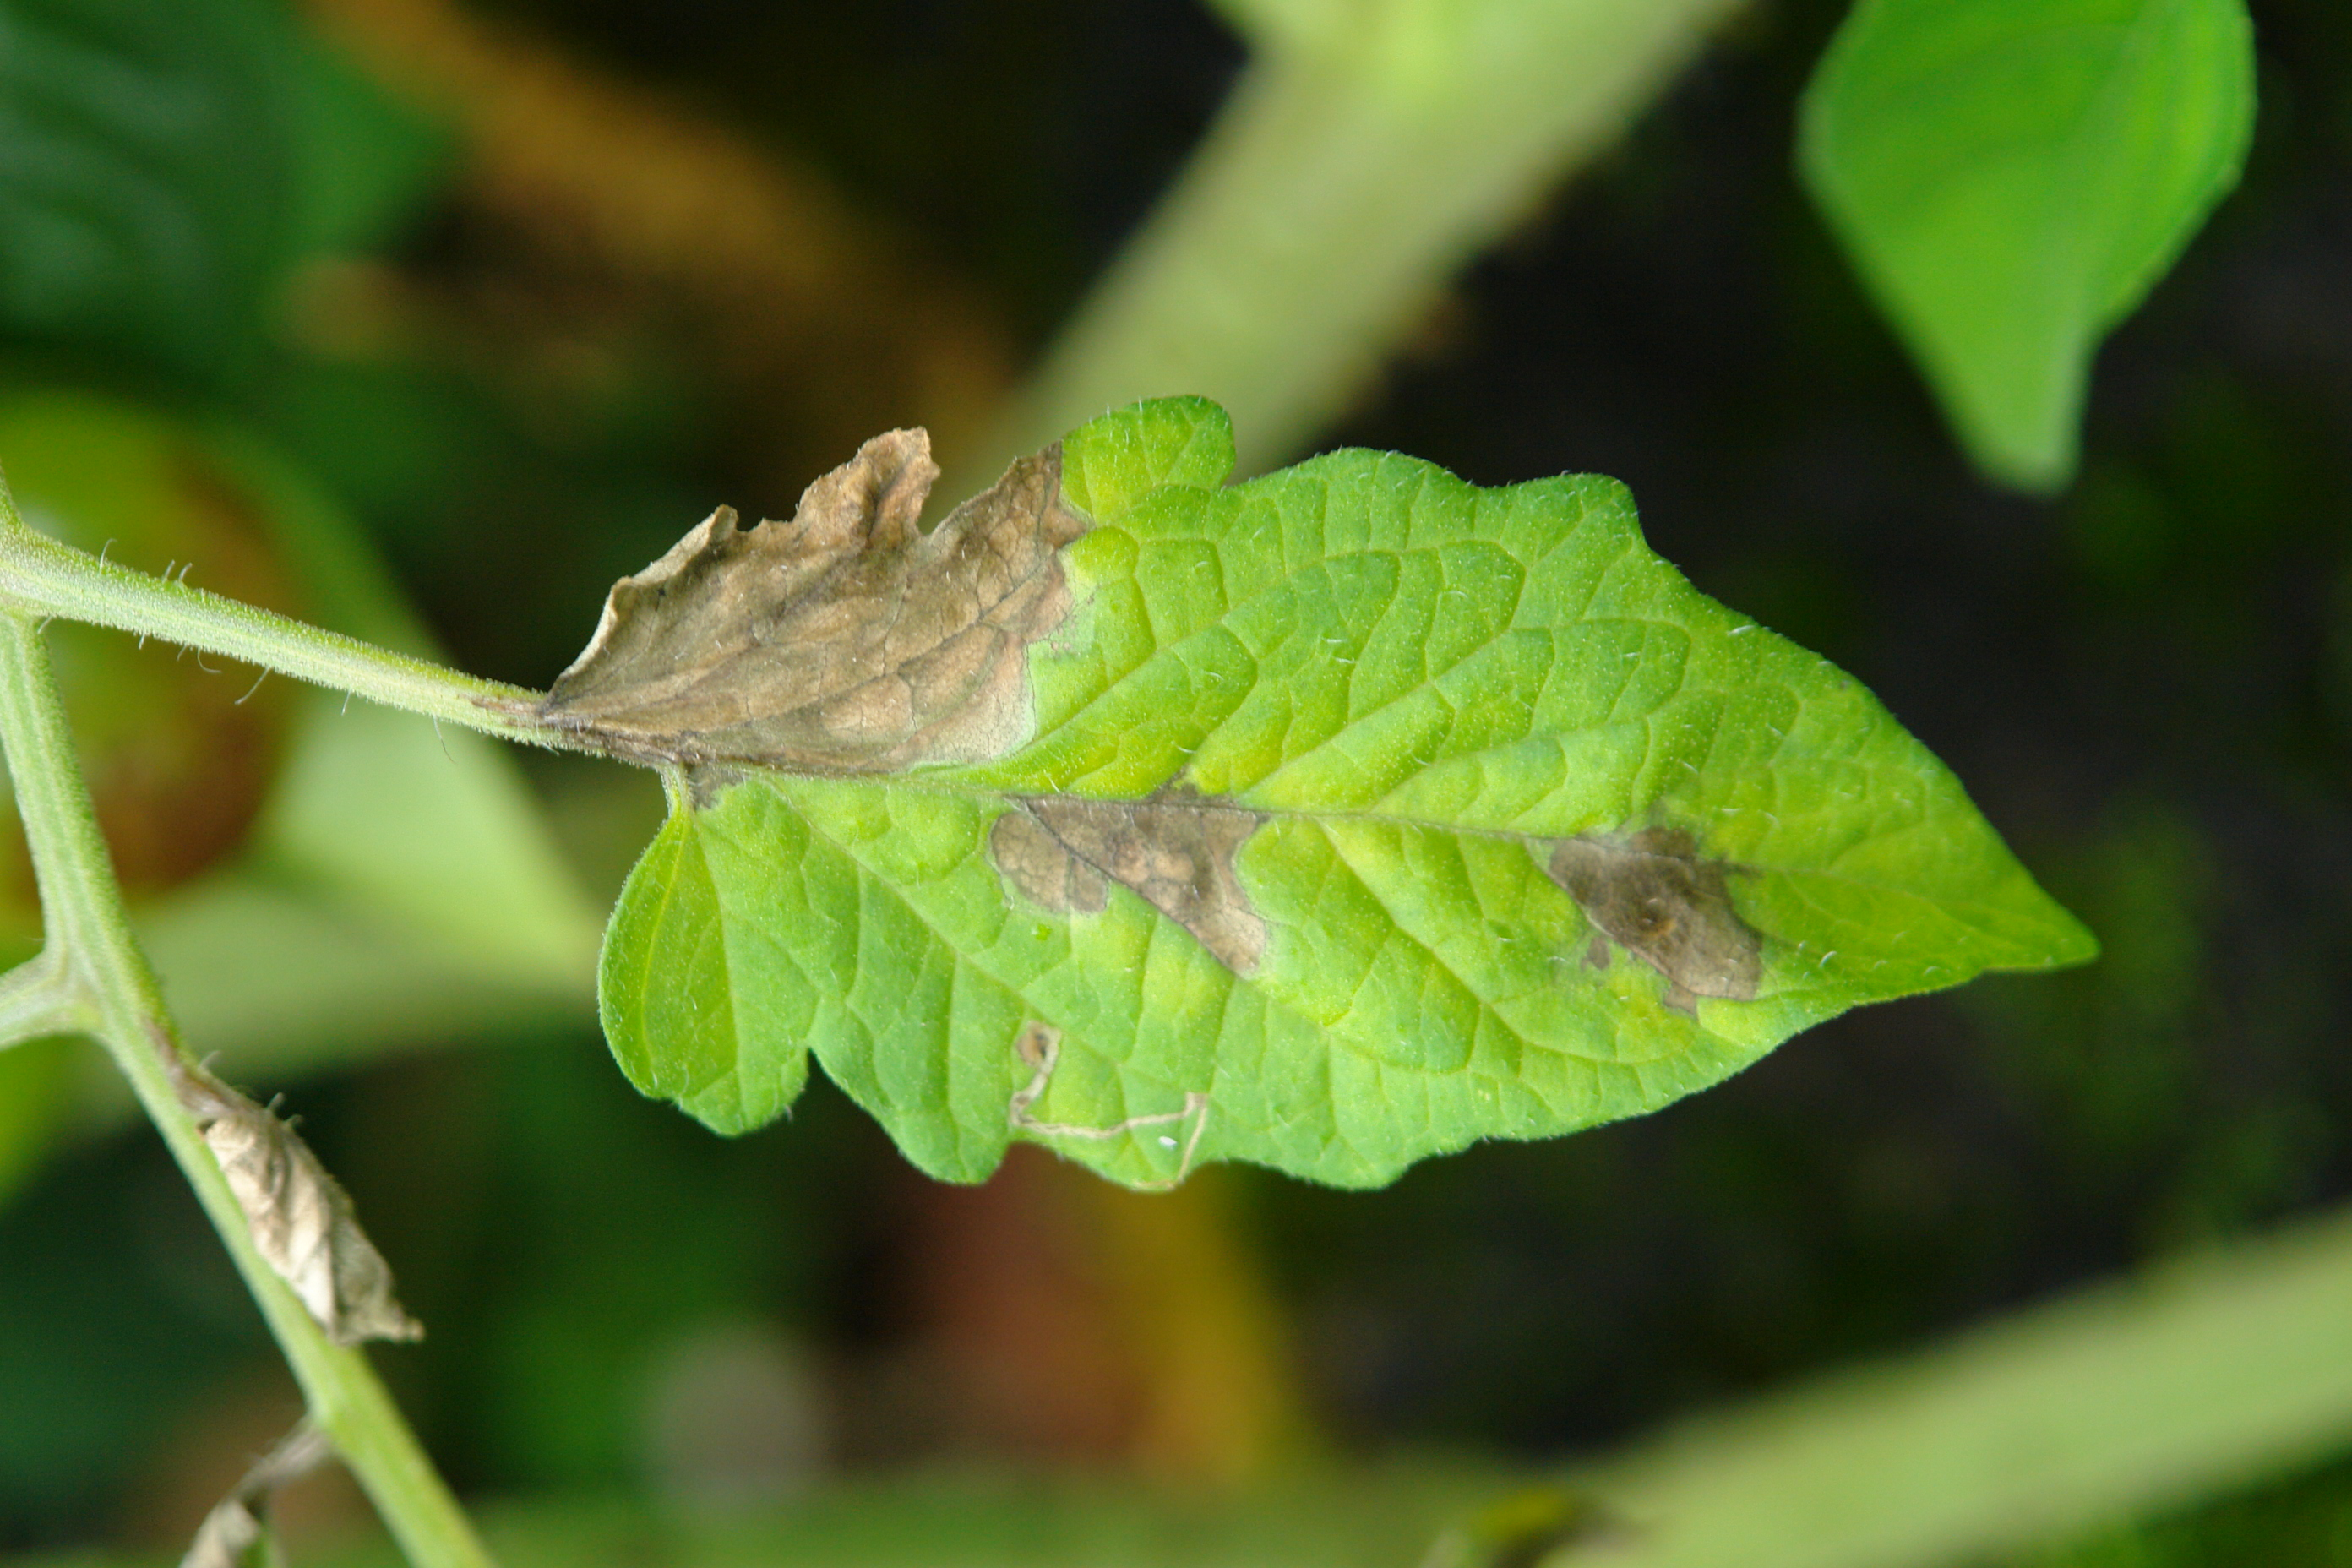

In [8]:
!wget -O tomato.jpg https://upload.wikimedia.org/wikipedia/commons/d/df/Tomato_late_blight_foliar_lesions_%285816740026%29.jpg
raw_image = Image.open("tomato.jpg").convert('RGB')
display(raw_image)

質問１

In [9]:
prompt = [
    {
        "speaker": "ユーザー",
        "text": "<Img><ImageHere></Img> What can you see?"
    }
]
prompt = [
    f"{uttr['speaker']}: {uttr['text']}"
    for uttr in prompt
]
prompt = "\n".join(prompt)
prompt = (
    prompt
    + "\n"
    + "システム: "
)
print(prompt)

ユーザー: <Img><ImageHere></Img> What can you see?
システム: 


In [10]:
image = vis_processor(raw_image).unsqueeze(0).to(model.device)
image_emb = model.encode_img(image)

embs = model.get_context_emb(prompt, [image_emb])

output_ids = model.gpt_neox_model.generate(
    inputs_embeds=embs,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.5,
    top_p=0.85,
    pad_token_id=tokenizer.pad_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

output = tokenizer.decode(output_ids.tolist()[0], skip_special_tokens=True)
print(output)

a leaf with a green stain on it


質問２

In [48]:
prompt = [
    {
        "speaker": "ユーザー",
        "text": "<Img><ImageHere></Img> What can you see?"
    },
    {
        "speaker": "システム",
        "text": "a tomato leaf"
    },
    {
        "speaker": "ユーザー",
        "text": "What disease is this leaf infected with?"
    },
]
prompt = [
    f"{uttr['speaker']}: {uttr['text']}"
    for uttr in prompt
]
prompt = "\n".join(prompt)
prompt = (
    prompt
    + "\n"
    + "システム: "
)
print(prompt)

ユーザー: <Img><ImageHere></Img> What can you see?
システム: a tomato leaf
ユーザー: What disease is this leaf infected with?
システム: 


In [53]:
image = vis_processor(raw_image).unsqueeze(0).to(model.device)
image_emb = model.encode_img(image)

embs = model.get_context_emb(prompt, [image_emb])

output_ids = model.gpt_neox_model.generate(
    inputs_embeds=embs,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.5,
    top_p=0.85,
    pad_token_id=tokenizer.pad_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id
)

output = tokenizer.decode(output_ids.tolist()[0], skip_special_tokens=True)
print(output)

tomato leaf disease


セルの出力を何回か繰り返すと以下のような答えが出てくることを確認できます。

- tomato leaf disease
- blight
- leaf wilt
- mildew

残念ながら、このような結果からは、果たしてユーザーが事前に与えたトマトの葉というプロンプトから関連しそうな病気を連想して返したのか、画像から推測して返したのかは判別できません。知るためには、bilingual-gpt-neox-4b-minigpt4がどのようなデータセットで訓練し、チューニングされてきたかを文献をたどり調べてから解釈するしかありません。

ただし、一般的な話として、LLM用の画像データセットは「一般的な画像」を集めて作られる傾向にあり、作物の病気のような特定ドメインの画像は少ない傾向にあります。一方で、もしこのモデルが植物病理学など農業分野の専門的なデータも追加学習していたとしたら、画像からある程度病気を推測できている可能性もあります。

LLMの訓練コストは本書で紹介した画像解析モデルに比べて膨大です。いずれ「巨人達」が専門ドメイン知識を網羅する時代が来るのか、それとも特定ドメインのLLMは専門家達が用意しなければいけないのかは見極めなければいけません。

## おまけ　（2024/4/26追記）
ChatGPT-4有償契約版では画像をアップロードし、解説を求めることができます。同じ画像をアップロードし、事前情報なしで問うたところ、以下の答えを得ました。

>This is an image of a tomato plant leaf with symptoms that are indicative of a plant disease, possibly late blight. Late blight is caused by the pathogen Phytophthora infestans and is characterized by dark, water-soaked lesions, often starting at the tips or edges of the leaves. It can quickly spread and is a serious concern for tomato and potato crops. It's always best to consult with a local plant pathologist or extension service for an accurate diagnosis and treatment options.

お見事。ただし、ChatGPT4がどのようなデータで訓練されているかは下の答えのように企業秘密です。

>During my training, I was exposed to a diverse range of datasets, including text and images from various sources on the internet. The specific details of these datasets are not disclosed for proprietary reasons, but it is likely that images and information from publicly available resources like Wikimedia Commons may have been included.

もしWikimedia Commons画像を含んでいた場合、上述の答えは訓練データに入っていたため答えられたと解釈すべきです。自身で用意した画像などの結果を踏まえ、慎重に解釈すべきでしょう。